# Additional Visualizations

This notebook will detail some extra statistics and visuals from our dataset. We'll need some imports to get things set up.

In [2]:
import os
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import panel as pn
import panel.widgets as pnw
import polars as pl

Here's a look at our dataset one last time

In [3]:
reviews_path = '../data/Steam Game Reviews export 2025-09-03 01-50-49.csv' # Replace with the path to your reviews CSV File
game_metadata_path = '../data/games_description.csv' # Replace with path to game metadata CSV file, NOTE make sure to go to parent dir in the path


steamreviews = pd.read_csv(reviews_path)
gamemetadata = pd.read_csv(game_metadata_path)
steamdataset = pd.merge(steamreviews, gamemetadata, left_on='game_name', right_on='name', how='left')
steamdataset.drop(columns=['name'], inplace=True)

steamdataset

,review,hours_played,helpful,funny,recommendation,date,game_name,username,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
0,The game itself is also super fun. The PvP and...,39.9,1152,13,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Sentinowl\n224 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
1,Never cared much about Warhammer until this ga...,91.5,712,116,Recommended,13 September,"Warhammer 40,000: Space Marine 2",userpig\n248 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
2,A salute to all the fallen battle brothers who...,43.3,492,33,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Imparat0r\n112 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
3,this game feels like it was made in the mid 20...,16.8,661,15,Recommended,14 September,"Warhammer 40,000: Space Marine 2",Fattest_falcon,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
4,Reminds me of something I've lost. A genuine g...,24.0,557,4,Recommended,12 September,"Warhammer 40,000: Space Marine 2",Jek\n410 products in account,Embody the superhuman skill and brutality of a...,About This Game\nEmbody the superhuman skill a...,"['Warhammer 40K', 'Action', 'Third-Person Shoo...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"9 Sep, 2024",['Saber Interactive'],['Focus Entertainment'],Very Positive,"(81% of 62,791) All Time","51,920",https://store.steampowered.com/app/2183900/War...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992148,2022 Early Access Review Loads of fun!Initiall...,4.2,1,0,Recommended,"August 4, 2022",Turbo Golf Racing,"Fatal Exit\n1,902 products in account",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992149,2022 Early Access Review Great fun!,8.5,1,0,Recommended,"August 4, 2022",Turbo Golf Racing,cleybaR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992150,2022 Early Access Review Excellent pick up and...,83.3,2,0,Recommended,"August 4, 2022",Turbo Golf Racing,Sim\n600 products in account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992151,2022 Early Access Review This game is so much ...,3.8,1,0,Recommended,"August 4, 2022",Turbo Golf Racing,Fatboybadboy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We'll need to do some preprocessing for the data:

In [4]:
steamdataset["genres"] = steamdataset["genres"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

steamdataset["release_year"] = steamdataset["release_date"].astype(str).str[-4:]
steamdataset["release_year"] = pd.to_numeric(steamdataset["release_year"], errors="coerce")

rating_map = {
    'Overwhelmingly Positive': 5,
    'Very Positive': 4,
    'Positive': 3,
    'Mixed': 2,
    'Negative': 1,
    'Very Negative': 0
}
steamdataset["rating_num"] = steamdataset["overall_player_rating"].map(rating_map)

#days since release (relative to when this code is run)
current_year = pd.Timestamp.today().year
steamdataset["days_since_release"] = (
    (current_year - steamdataset["release_year"]) * 365
)

steamdataset[["overall_player_rating", "rating_num", "release_year", "days_since_release"]].head(50000)

,overall_player_rating,rating_num,release_year,days_since_release
0,Very Positive,4.0,2024.0,365.0
1,Very Positive,4.0,2024.0,365.0
2,Very Positive,4.0,2024.0,365.0
3,Very Positive,4.0,2024.0,365.0
4,Very Positive,4.0,2024.0,365.0
...,...,...,...,...
49995,Mixed,2.0,2022.0,1095.0
49996,Mixed,2.0,2022.0,1095.0
49997,Mixed,2.0,2022.0,1095.0
49998,Mixed,2.0,2022.0,1095.0


### Graph 1

Finding the average ratio of recommended vs non-recommended games by genre and release year

To solve this, we'l employ a heatmap

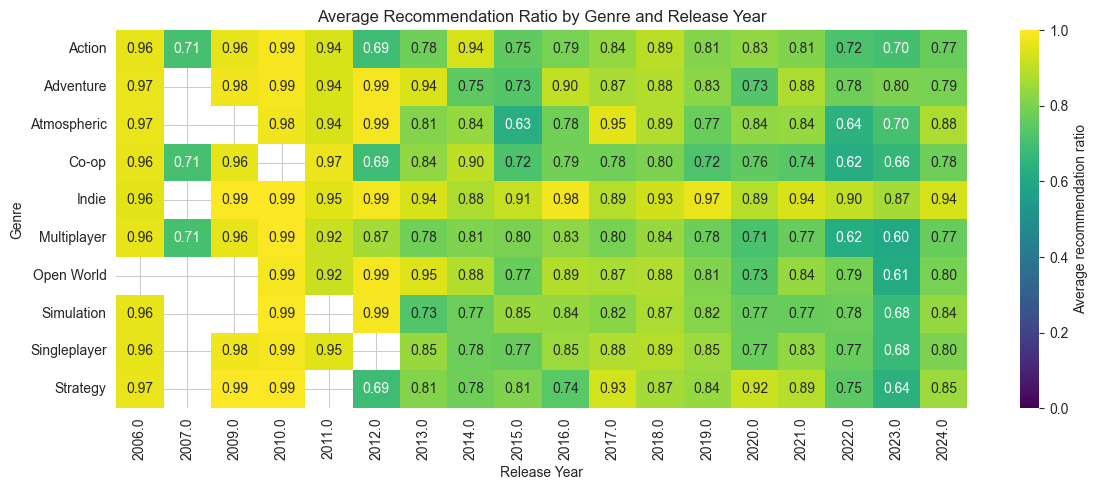

In [6]:
sns.set_style("whitegrid")

steamdataset["rec_ratio"] = steamdataset["recommendation"].map({
        "Recommended": 1,
        "Not Recommended": 0
    })
exploded = steamdataset.explode("genres")

#top 10 genres by frequency
top_genres = exploded["genres"].value_counts().head(10).index.tolist()
top_genre_df = exploded[exploded["genres"].isin(top_genres)].copy()

#compute mean rec_ratio by (genre, release_year)
heat_df = top_genre_df.groupby(["genres", "release_year"])["rec_ratio"].mean().reset_index()

heat_pivot = heat_df.pivot(
    index="genres",
    columns="release_year",
    values="rec_ratio"
)

plt.figure(figsize=(12, 5))
sns.heatmap(
    heat_pivot,
    cmap="viridis",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "Average recommendation ratio"}
)
plt.title("Average Recommendation Ratio by Genre and Release Year")
plt.xlabel("Release Year")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

### Graph 2

Interactive plotly graph between ratio of recommended vs non-recommended games and hours played

In [7]:
bins = [0, 1, 5, 10, 20, 50, 100, 200, 500, 100000]
labels = ["<1", "1–5", "5–10", "10–20", "20–50", "50–100", "100–200", "200–500", "500+"]

#bands for hours played
steamdataset["hours_band"] = pd.cut(
    steamdataset["hours_played"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

hours_rec = steamdataset.groupby("hours_band")["rec_ratio"].mean().reset_index().dropna()

fig = px.line(
    hours_rec,
    x="hours_band",
    y="rec_ratio",
    markers=True,
    title="Recommendation Ratio vs Hours Played",
    labels={
        "hours_band": "Hours Played (binned)",
        "rec_ratio": "Share of Reviews that Recommend the Game"
    }
)

fig.update_yaxes(range=[0, 1])

fig.show()

/var/folders/h6/nnzy69c13sn43ypbbpk2877m0000gn/T/ipykernel_53595/3978752352.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hours_rec = steamdataset.groupby("hours_band")["rec_ratio"].mean().reset_index().dropna()


### Graph 3

RUN `01_explore` BEFORE STARTING HERE

A word cloud to see what kind of words are used to describe good vs bad reviews. There is also a list of recommended vs not recommended words to use here.

In [6]:
#TODO

In [5]:
steamdataset = steamdataset.dropna()

In [6]:
import re

def remove_leading_year(text):
    text = str(text)
    
    # Remove a 4-digit year at the start, optional period or colon, and whitespace
    text = re.sub(r'^\s*early access review[:.\- ]*\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^\s*product received for free[:.\- ]*\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^\s*product refunded[:.\- ]*\s*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'^\s*\b(19|20)\d{2}\b[:.\- ]*\s*', '', text)
    return text

steamdataset.loc[:, 'review'] = steamdataset['review'].astype(str).apply(remove_leading_year)


In [7]:
df_sample = steamdataset.groupby('recommendation').sample(frac=0.05)
df_sample['recommendation'] = (df_sample['recommendation'] == 'Recommended').astype(int)
df_sample = df_sample.reset_index(drop=True)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df_sample['review'])

df_cv = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
df_cv['recommendation'] = df_sample['recommendation']

# Only numeric columns (TF-IDF features)
tfidf_cols = tfidf.get_feature_names_out()  # only word features

recommended_words = (
    df_cv[df_cv['recommendation'] == 1][tfidf_cols]
    .sum()
    .sort_values(ascending=False)
)

# Drop the first 5 most common words
recommended_words = recommended_words.iloc[5:]

not_recommended_words = (
    df_cv[df_cv['recommendation'] == 0][tfidf_cols]
    .sum()
    .sort_values(ascending=False)
)

not_recommended_words = not_recommended_words.iloc[5:]


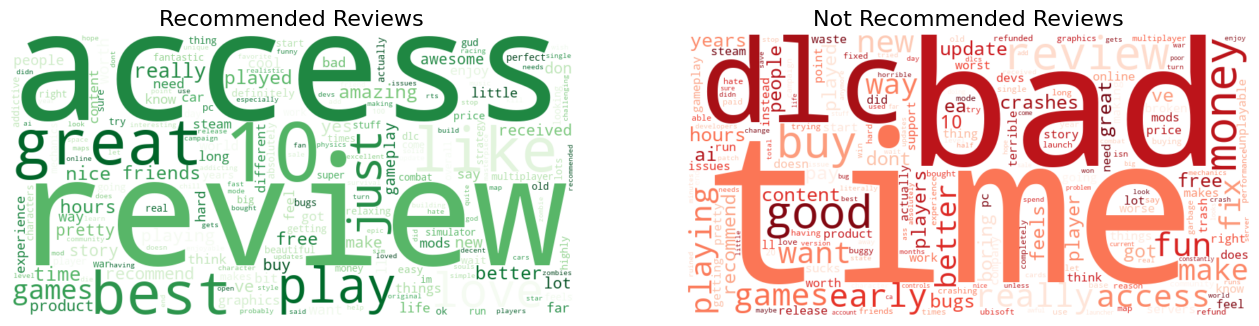

In [9]:
from wordcloud import WordCloud

# Recommended
wc_rec = WordCloud(width=800, height=400, background_color='white', colormap='Greens')
wc_rec.generate_from_frequencies(recommended_words)

# Not Recommended
wc_not = WordCloud(width=800, height=400, background_color='white', colormap='Reds')
wc_not.generate_from_frequencies(not_recommended_words)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(wc_rec, interpolation='bilinear')
plt.axis('off')
plt.title('Recommended Reviews', fontsize=16)

plt.subplot(1,2,2)
plt.imshow(wc_not, interpolation='bilinear')
plt.axis('off')
plt.title('Not Recommended Reviews', fontsize=16)
plt.show()


## Graph 3.5

Extension of graph 3 and text analysis

In [10]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  # small, fast
embeddings = model.encode(df_sample['review'].tolist(), batch_size=64, show_progress_bar=True)


Batches:   0%|          | 0/658 [00:00<?, ?it/s]

In [21]:
import umap
umap_reducer = umap.UMAP(n_components=50, n_neighbors=15, min_dist=0.1, random_state=42)
X_reduced = umap_reducer.fit_transform(embeddings)

/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean')
clusters = clusterer.fit_predict(X_reduced)
df_sample['cluster'] = clusters

pd.crosstab(df_sample['cluster'], df_sample['recommendation'])

/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


recommendation,0,1
cluster,,
-1,3,513
0,0,215
1,7337,34013


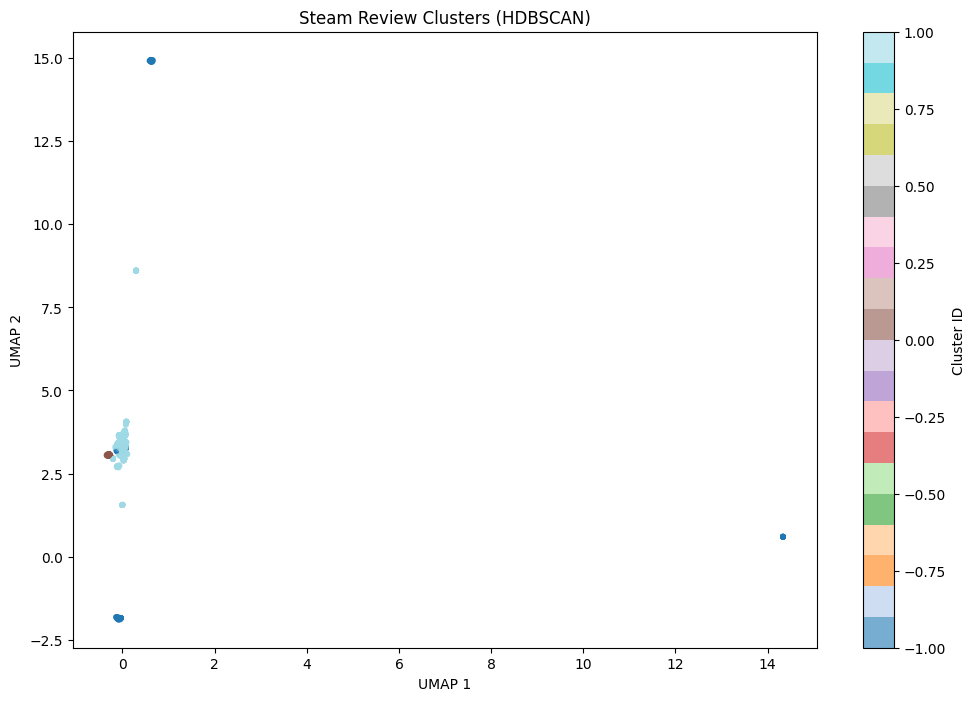

In [23]:
plt.figure(figsize=(12, 8))
plt.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=df_sample['cluster'],  # cluster ID
    cmap='tab20',            # categorical colormap
    alpha=0.6,
    s=10
)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Steam Review Clusters (HDBSCAN)')
plt.colorbar(label='Cluster ID')
plt.show()


In [27]:
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# --------------------------
# 0️⃣ Suppress warnings
# --------------------------
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# --------------------------
# 1️⃣ Prepare text
# --------------------------
df_sample['clean_review'] = (
    df_sample['review']
    .str.lower()
    .str.replace(r'\d+', '', regex=True)
    .str.replace(r'[^a-z\s]', '', regex=True)
)

# Filter for longer reviews
MIN_LENGTH = 50
df_filtered = df_sample[df_sample['clean_review'].str.len() > MIN_LENGTH].copy()
print(f"Reviews after filtering: {len(df_filtered)}")

# --------------------------
# 2️⃣ Compute embeddings
# --------------------------
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_filtered['clean_review'].tolist(), batch_size=64, show_progress_bar=True)

Reviews after filtering: 26941


Batches:   0%|          | 0/421 [00:00<?, ?it/s]

In [29]:
# --------------------------
# 3️⃣ Compute sentiment scores
# --------------------------
analyzer = SentimentIntensityAnalyzer()
df_filtered['sentiment'] = df_filtered['clean_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Combine embeddings + sentiment
X_combined = np.hstack([embeddings, df_filtered['sentiment'].values.reshape(-1,1)])

In [30]:
# --------------------------
# 4️⃣ Reduce dimensions with UMAP (50 dims)
# --------------------------
umap_reducer = umap.UMAP(n_components=50, n_neighbors=15, min_dist=0.1, random_state=42)
X_reduced = umap_reducer.fit_transform(X_combined)


/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
# --------------------------
# 5️⃣ Cluster with HDBSCAN
# --------------------------
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean')
clusters = clusterer.fit_predict(X_reduced)
df_filtered['cluster'] = clusters

/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters (excluding outliers): 4
Cluster counts:
cluster
 3    18003
-1     6830
 1     1373
 0      461
 2      274
Name: count, dtype: int64

Top words per cluster:
Cluster 3 (18003 reviews, 74.88% Recommended): ['game', 'like', 'just', 'play', 'good', 'time', 'games', 'fun', 'review', 'early']
Cluster -1 (6830 reviews, 84.70% Recommended): ['game', 'like', 'just', 'good', 'play', 'time', 'games', 'really', 'fun', 'dont']
Cluster 1 (1373 reviews, 85.00% Recommended): ['game', 'like', 'just', 'good', 'cars', 'really', 'fun', 'car', 'racing', 'great']
Cluster 0 (461 reviews, 87.20% Recommended): ['free', 'game', 'received', 'product', 'play', 'good', 'like', 'fun', 'great', 'just']
Cluster 2 (274 reviews, 77.74% Recommended): ['game', 'cards', 'card', 'play', 'like', 'just', 'fun', 'deck', 'games', 'dont']


/Users/hammy/Projects/DataVisProj/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


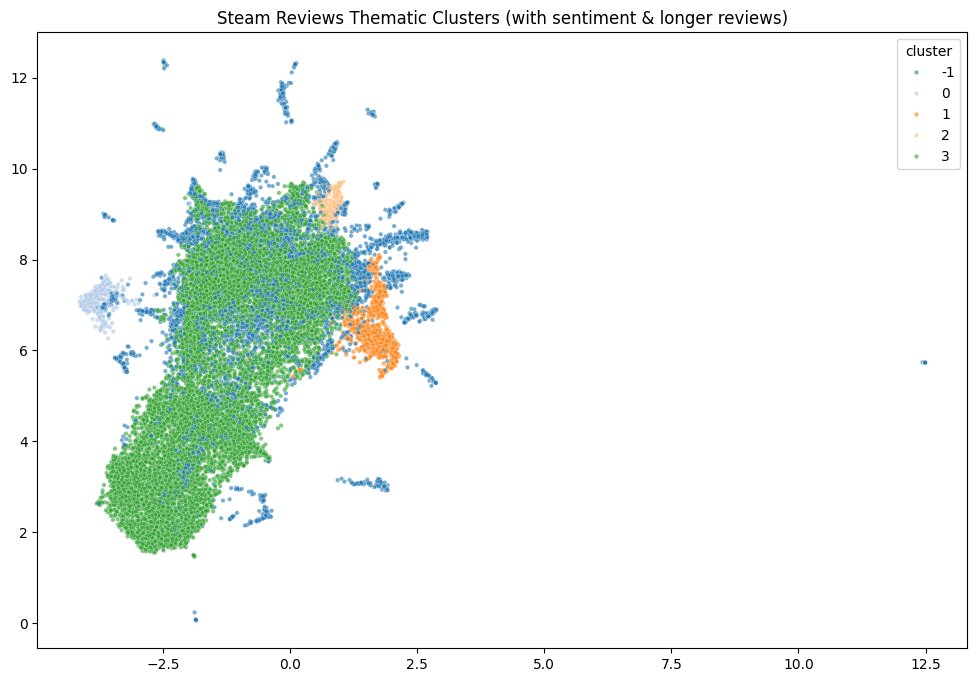

Number of outlier reviews: 6830
                                                  review  recommendation
29741  "Best. Sandbox. Game. Ever. Play this game wit...               1
13605  Review by Gaming Masterpieces - The greatest g...               1
29171  I literally just fish and play a children's ca...               1
29669  Nice penalty system,physical mechanics,drive f...               1
27654  I was playing this game in ubi play, now in st...               1
22802  Very fun, and a lot of content if you enjoy tr...               1
31812  The most fun I have had with a Sonic game in y...               1
21179  Awesome MMORPG. Well done story line and lore....               1
35051  good game apart from a few ai voice lines and ...               1
25857  So, this is a hard one.JWE2 is an awesome game...               1


In [40]:

print("Number of clusters (excluding outliers):", len(set(clusters)) - (1 if -1 in clusters else 0))
print("Cluster counts:")
print(df_filtered['cluster'].value_counts().head(10))

# --------------------------
# 6️⃣ Top words per cluster
# --------------------------
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_counts = vectorizer.fit_transform(df_filtered['clean_review'])
feature_names = vectorizer.get_feature_names_out()
df_counts = pd.DataFrame(X_counts.toarray(), columns=feature_names)

top_clusters = df_filtered['cluster'].value_counts().head(10).index

print("\nTop words per cluster:")
for c in top_clusters:
    # Get integer positions of rows in this cluster
    cluster_idx = np.where(df_filtered['cluster'].values == c)[0]
    
    # Select rows in df_counts using iloc
    top_words = df_counts.iloc[cluster_idx].sum().sort_values(ascending=False).head(10)
    
    # Fraction of Recommended reviews
    prop_recommended = df_filtered['recommendation'].iloc[cluster_idx].mean()
    
    print(f"Cluster {c} ({len(cluster_idx)} reviews, {prop_recommended:.2%} Recommended): {top_words.index.tolist()}")




# --------------------------
# 7️⃣ Visualize clusters (2D UMAP for plotting only)
# --------------------------
X_2d = umap.UMAP(n_components=3, random_state=42).fit_transform(X_combined)

plt.figure(figsize=(12,8))
sns.scatterplot(
    x=X_2d[:,0], y=X_2d[:,1],
    hue=df_filtered['cluster'],
    palette='tab20',
    legend='full',
    alpha=0.6,
    s=10
)
plt.title('Steam Reviews Thematic Clusters (with sentiment & longer reviews)')
plt.show()

# --------------------------
# 8️⃣ Optional: Examine outliers
# --------------------------
outliers = df_filtered[df_filtered['cluster'] == -1]
print(f"Number of outlier reviews: {len(outliers)}")
print(outliers[['review','recommendation']].sample(10, random_state=42))
